In [1]:
import jax
import numpy as np
import pandas as pd
import random

class MaskSVDSimulator(object):
    def __init__(self, 
                 study_names: list,     # list of study names
                 sample_nums: list,     # list of numbers, the sample number of each studies
                 feature_dim: int,      # number of species
                 latent_dim: int,       # number of latent Sigma matrix
                 noise_ratio: float,    # noise ratio, ratio of E and Sigma
                 ):  
        
        self.study_names = study_names
        self.sample_nums = sample_nums
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.noise_ratio = noise_ratio

        self.num_of_studies = len(study_names)
        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.V = None
        self.Cs = list()
        self.X = None

    
    def _gen_random_ortho(self, n: int, k:int):
        random_matrix = np.random.rand(n, n)
        q, _ = np.linalg.qr(random_matrix)
        return q[:, :k]
    
    def _assign_features(self, avg_prop=0.4): # assign the considered features (species) for each study
        self.Cs = list()
        for i in range(self.num_of_studies):
            prop = np.random.uniform(0.5, 1.5) * avg_prop
            prop = np.min([prop, 1.0])
            study_feature_dim = round(self.feature_dim*prop)
            
            C_list = [1]*study_feature_dim + [0]*(self.feature_dim-study_feature_dim)
            random.shuffle(C_list)
            self.Cs.append(np.diag(C_list))

    def _clear_all(self):
        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.V = None
        self.Cs = list()
    
    def _concat_Xs(self):
        assert len(self.Xs) == self.num_of_studies

        repeated_study_names = [self.study_names[i] for i in range(self.num_of_studies) for _ in range(self.sample_nums[i])]
        feature_names = [f'species_{i}' for i in range(self.feature_dim)]
        X = np.vstack(self.Xs)

        self.X = pd.DataFrame({'study_names': repeated_study_names, **dict(zip(feature_names, X.T))})
        type_dict = {'study_names': str}
        for col_names in self.X.columns[1:]:
            type_dict[col_names] = float
        self.X = self.X.astype(type_dict)
        return self.X

    def simulate(self, magnitude = 10000, new_V=False): # new_V means we remove the current V matrix and generate a new one
        self._assign_features()
        if new_V or self.V is None: 
            self.V = self._gen_random_ortho(self.feature_dim, self.latent_dim)
        for i in range(self.num_of_studies):            
            # generate Sigma by an inverse gamma distribution
            alpha = np.random.uniform(2.0, 4.0)
            beta = np.random.uniform(0.5, 1.5)
            sigma_list = 1/np.random.gamma(alpha, scale=beta, size=self.latent_dim)
            sigma_list = np.sort(sigma_list)[::-1]

            Sigma = np.diag(magnitude * sigma_list)
            self.Sigmas.append(Sigma)

            # generate U
            U = self._gen_random_ortho(self.sample_nums[i], self.latent_dim)
            self.Us.append(U)

            # generate noise 
            noise_level = np.max(sigma_list) * self.noise_ratio
            E = np.random.normal(0, noise_level, size=(self.sample_nums[i], self.feature_dim))

            X = U@Sigma@self.V.T@self.Cs[i]
            self.Xs.append(X)

        assert self.X is None
        self._concat_Xs()
        return self.X

In [2]:
study_names = ['A', 'B', 'C']
sample_nums = [100, 150, 200, 250, 300]
feature_dim = 200
latent_dim = 20
noise_ratio = 0.1
magnitude = 10000

simulator = MaskSVDSimulator(study_names, sample_nums, feature_dim, latent_dim, noise_ratio)
X = simulator.simulate(magnitude=magnitude)

In [3]:
X

,study_names,species_0,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,...,species_190,species_191,species_192,species_193,species_194,species_195,species_196,species_197,species_198,species_199
0,A,0.000000,-85.021057,0.000000,0.0,0.000000,0.000000,0.0,0.0,-10.075062,...,0.0,0.000000,0.000000,236.631425,0.000000,0.0,167.891451,-113.072411,0.0,0.0
1,A,0.000000,385.398895,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.141767,...,0.0,0.000000,0.000000,-151.088556,0.000000,0.0,48.829858,105.656566,0.0,0.0
2,A,0.000000,237.181760,0.000000,0.0,0.000000,0.000000,0.0,0.0,21.088507,...,0.0,0.000000,0.000000,113.334083,0.000000,0.0,153.942440,507.637339,0.0,0.0
3,A,0.000000,142.627891,0.000000,0.0,0.000000,0.000000,0.0,0.0,268.132892,...,0.0,0.000000,0.000000,-64.131091,0.000000,0.0,-242.714808,8.844179,0.0,0.0
4,A,0.000000,498.685809,0.000000,0.0,0.000000,0.000000,0.0,0.0,233.987449,...,0.0,0.000000,0.000000,239.401354,0.000000,0.0,-41.280894,189.357028,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,C,484.003045,199.643734,718.343151,0.0,751.478230,-170.726038,0.0,0.0,883.323421,...,0.0,-112.182139,330.829141,818.357543,57.529156,0.0,0.000000,202.326236,0.0,0.0
446,C,956.190177,325.333940,-192.877397,0.0,-5.144571,278.801058,0.0,0.0,442.372688,...,0.0,479.889672,18.958837,569.785015,248.714817,0.0,0.000000,466.714168,0.0,0.0
447,C,478.777464,337.705784,-26.940197,0.0,-28.325437,-216.637600,0.0,0.0,287.872976,...,0.0,208.252628,-62.828514,333.510134,-231.893553,0.0,0.000000,290.629800,0.0,0.0
448,C,496.175775,568.590325,553.173688,0.0,525.980988,175.367587,0.0,0.0,920.149524,...,0.0,198.405532,539.645868,721.196400,549.816718,0.0,0.000000,132.166180,0.0,0.0


In [5]:
X_val = X.iloc[:, 1:].values

<AxesSubplot:>

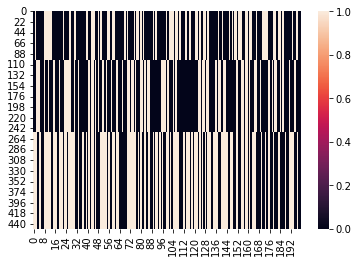

In [6]:
import seaborn as sns

sns.heatmap(X_val != 0)

<AxesSubplot:>

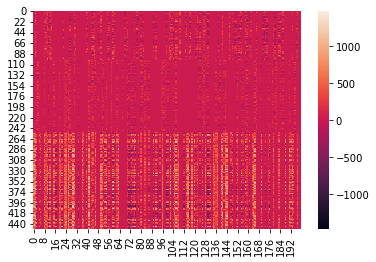

In [7]:
sns.heatmap(X_val)

In [8]:
X.to_csv("simulated_data.csv")